In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [237]:
def load_npy(filename):
    return np.load(filename)

In [238]:
dir_path = 'timeseries/'
len_threshold = 1280

In [239]:
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation
        ts = np.append(ts, pad) 

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

In [240]:
!pip install sktime==0.25.0

In [241]:
from sktime.transformations.panel.dictionary_based import PAA

In [242]:
def approximate(ts, approx):
    return approx.fit_transform(ts)

(1280,)

In [243]:
paa = PAA(num_intervals=128) # Piecewise Aggregate Approximation w. 100 intervals

In [244]:
X_paa = np.array([[approximate(ts[0], paa)[:,0]] for ts in X])
X_paa.shape


(10000, 1, 128)

In [53]:
X_paa.T

array([[[1261.8060834 , 2844.99294673, 2145.52498401, ...,
         3059.19096924, 1631.08342794, 2238.78389958]],

       [[1943.33267743, 2368.32527189, 2031.61507061, ...,
         4756.15842154, 2295.61788455, 1724.75352366]],

       [[1988.51854672, 2492.66900832, 2906.1902754 , ...,
         3834.9123108 , 2623.00160011, 2441.45529157]],

       ...,

       [[1509.29170807, 1426.80717856, 2565.09630595, ...,
         3686.80309496, 3505.00310256, 2367.24179709]],

       [[1345.16515871, 1286.18571001, 1894.27529729, ...,
         4058.29464563, 3229.20131498, 2482.96872101]],

       [[1392.81694074, 1945.78439383, 3266.60453235, ...,
         4406.66618349, 2047.54811707, 2465.53473694]]])

In [245]:
pip install saxpy

Note: you may need to restart the kernel to use updated packages.


In [250]:
X_train_paa, X_test_paa, y_train, y_test  = train_test_split (
 X_paa, y, test_size=0.2, random_state=42,
stratify=y )
X_train_paa.shape, X_test_paa.shape, y_train.shape, y_test.shape

((8000, 1, 128), (2000, 1, 128), (8000,), (2000,))

(128, 1, 10000)

In [246]:
!pip install tslearn

In [247]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict


In [252]:
y_train = y_train
y_test = y_test
X_train=X_train_paa
X_test=X_test_paa

In [236]:
y_train_small.shape

(1000,)

In [253]:
n_ts, ts_sz = X_train.shape[0], X_train.shape[2]

n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 8000
ts_sz 128
n_classes 20
shapelet_sizes {12: 7}


In [254]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_test)

dummy_clf.score(X_test, y_test)

0.05

In [255]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=100,
                        verbose=1)

/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [256]:
shp_clf.fit(X_train, y_train)

ValueError: Sizes in X do not match maximum shapelet size: there is at least one series in X that is shorter than one of the shapelets. Shortest time series is of length 1 and longest shapelet is of length 12

In [119]:
y_pred = shp_clf.predict(X_test)

NotFittedError: This LearningShapelets instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [118]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))


NameError: name 'accuracy_score' is not defined

((8000, 1, 128), (2000, 1, 128), (8000,), (2000,))

Forma e X_paa_primo: (1000, 1, 128)


(10000,)

Forma aktuale e y: (10000,)
Forma e re e y: (1000,)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

# CNN Classifier

In [128]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization


In [257]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [258]:
X_train_cnn = np.swapaxes(X_train_scaled, 1, 2)
X_test_cnn = np.swapaxes(X_test_scaled, 1, 2)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  20


In [259]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1, 128), (2000, 1, 128), (8000,), (2000,))

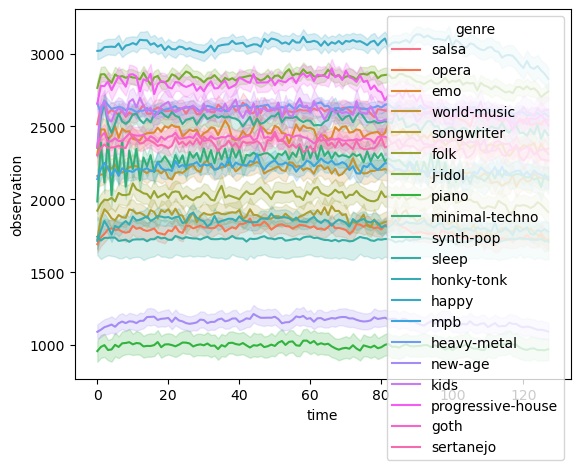

In [260]:
df = pd.DataFrame(np.squeeze(X_train))
df["genre"] = y_train
df_melt = df.melt(value_name="observation", var_name="time", id_vars="genre")
sns.lineplot(df_melt, x="time", y="observation", estimator="mean", hue="genre")
plt.show()

# Normalization

In [141]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

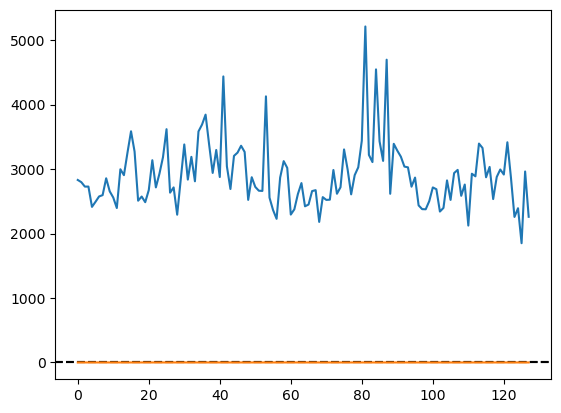

In [155]:
X_train_scaled.min(axis=(1, 2)), X_train_scaled.max(axis=(1, 2))
plt.plot(X_train[0].ravel())
plt.axhline(0, color="black", linestyle="--")
plt.axhline(1, color="black", linestyle="--")
plt.plot(X_train_scaled[0].ravel())

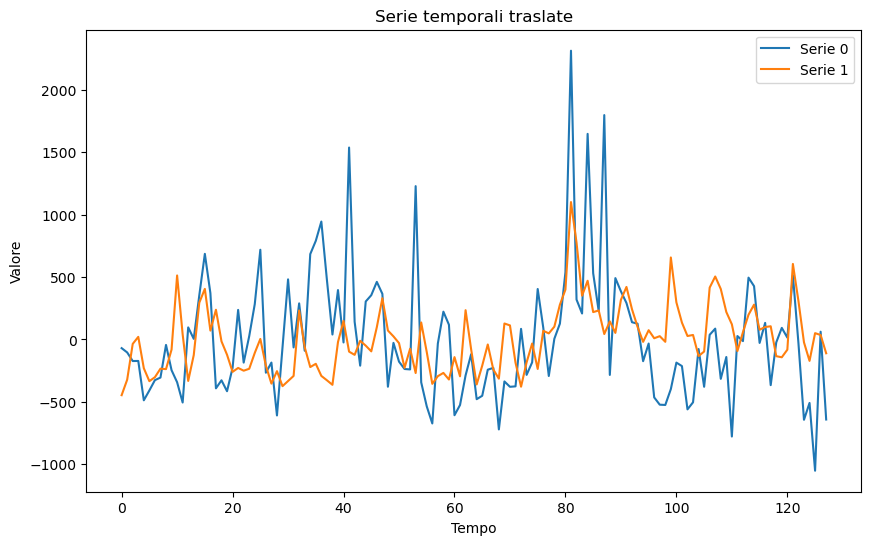

In [147]:
# Calcola il valore medio di ciascuna serie temporale nel DataFrame, escludendo la colonna 'genre'
valori_medi = df.drop(columns=['genre']).mean(axis=1)

# Sottrai il valore medio da ciascuna serie temporale nel DataFrame
df_tras = df.drop(columns=['genre']).sub(valori_medi, axis=0)

# Aggiungi la colonna 'genre' al DataFrame traslato
df_tras['genre'] = df['genre']

# Visualizza il DataFrame con le serie temporali traslate



# Calcola il valore medio di ciascuna serie temporale nel DataFrame, escludendo la colonna 'genre'
valori_medi = df.drop(columns=['genre']).mean(axis=1)

# Sottrai il valore medio da ciascuna serie temporale nel DataFrame
df_tras = df.drop(columns=['genre']).sub(valori_medi, axis=0)

# Limita il numero di serie temporali da visualizzare
num_serie_visualizzate = 2
serie_visualizzate = df_tras.head(num_serie_visualizzate)  # Utilizza il DataFrame traslato

# Visualizza le serie temporali traslate su un grafico
plt.figure(figsize=(10, 6))
for idx, row in serie_visualizzate.iterrows():
    plt.plot(row, label=f"Serie {idx}")  # Traccia ogni serie temporale traslata
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.title('Serie temporali traslate')
plt.legend()  # Aggiungi la legenda
plt.show()

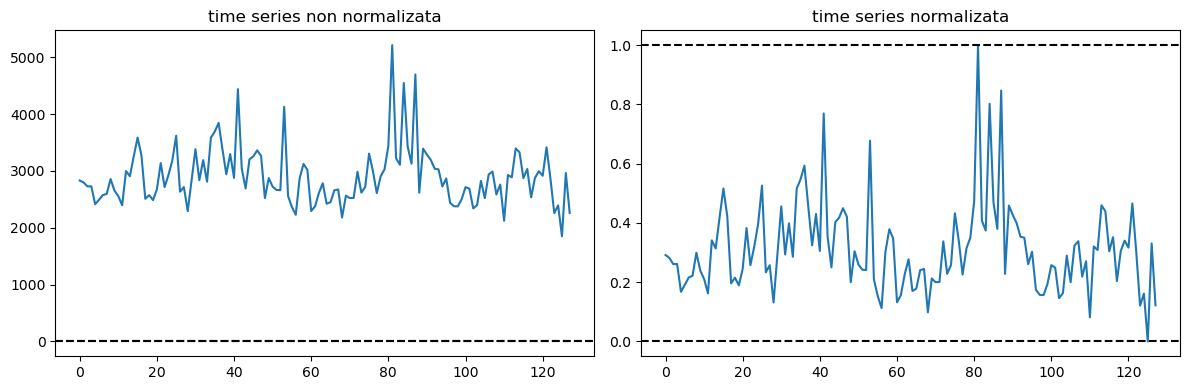

In [225]:
import matplotlib.pyplot as plt

# Ndaj grafikët në dy kolona
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Grafiku i parë për serinë kohore të pa-skualruar
axs[0].plot(X_train[0].ravel())
axs[0].axhline(0, color="black", linestyle="--")
axs[0].axhline(1, color="black", linestyle="--")
axs[0].set_title('time series non normalizata')

# Grafiku i dytë për serinë kohore të skaluar
axs[1].plot(X_train_scaled[0].ravel())
axs[1].axhline(0, color="black", linestyle="--")
axs[1].axhline(1, color="black", linestyle="--")
axs[1].set_title('time series normalizata')

# Rregullo pamjen
plt.tight_layout()
plt.show()



# Classification

In [157]:
from sktime.classification.deep_learning import CNNClassifier
import tensorflow as tf
from tensorflow import keras

Using sktime
easier, but there is no option to monitor the val loss to check for overfitting

In [158]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [159]:
%%time
cnn.fit(X_train_scaled, y_train)
cnn.score(X_test_scaled, y_test)

/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: user 1.02 s, sys: 220 ms, total: 1.24 s
Wall time: 1.25 s


0.05

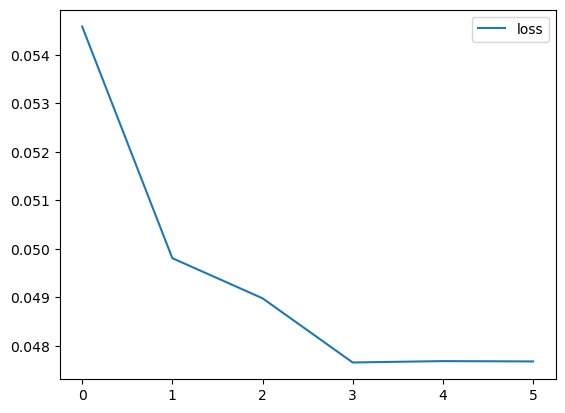

In [160]:
sns.lineplot(cnn.history.history["loss"], label="loss")
plt.show()

In [161]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LeakyReLU
from keras.layers import Activation, Conv1D, BatchNormalization
from keras.callbacks import EarlyStopping

In [162]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [163]:
X_train_cnn = np.swapaxes(X_train_scaled, 1, 2)
X_test_cnn = np.swapaxes(X_test_scaled, 1, 2)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  20


ValueError: cannot reshape array of size 128000 into shape (1000,1,1)

In [164]:
cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 121, 16)        │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 121, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 121, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 117, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 117, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 115, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 115, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 115, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 115, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,692 (41.77 KB)

 Trainable params: 10,468 (40.89 KB)

 Non-trainable params: 224 (896.00 B)

In [186]:
es = EarlyStopping(monitor="loss", patience=100, restore_best_weights=True)
callbacks = [es]


In [191]:
# Shikoni formatin e të dhënave të hyrjes
print("Formati i X_train_cnn:", X_train_cnn.shape)

# Shikoni strukturën e modelit CNN
print("Struktura e modelit CNN:")
print(cnn.summary())
from keras.callbacks import EarlyStopping

# Konfiguroni shkëputësin e ndaljes së hershme
es = EarlyStopping(monitor="loss", patience=100, restore_best_weights=True)
callbacks = [es]
# Filloni trajnimin e modelit
history = cnn.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)


Formati i X_train_cnn: (1000, 128, 1)
Struktura e modelit CNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 121, 16)        │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 121, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 121, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 117, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 117, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 115, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 115, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 115, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 115, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,692 (41.77 KB)

 Trainable params: 10,468 (40.89 KB)

 Non-trainable params: 224 (896.00 B)

None


ValueError: Invalid dtype: str544

In [192]:
print("Tipi i të dhënave për X_train_cnn:", X_train_cnn.dtype)
print("Tipi i të dhënave për y_train:", y_train.dtype)


Tipi i të dhënave për X_train_cnn: int64
Tipi i të dhënave për y_train: <U17


In [193]:
from sklearn.preprocessing import LabelEncoder

# Krijo një instance të LabelEncoder
label_encoder = LabelEncoder()

# Kodifikoni etiketat
y_train_encoded = label_encoder.fit_transform(y_train)
 

In [194]:
y_train=y_train_encoded

In [195]:
%%time
cnn.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0461 - loss: 3.0265 - val_accuracy: 0.0533 - val_loss: 2.9957
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0631 - loss: 3.0132 - val_accuracy: 0.0533 - val_loss: 2.9956
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0539 - loss: 3.0054 - val_accuracy: 0.0533 - val_loss: 2.9956
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0678 - loss: 2.9975 - val_accuracy: 0.0533 - val_loss: 2.9957
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0757 - loss: 2.9998 - val_accuracy: 0.0533 - val_loss: 2.9958
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0802 - loss: 2.9985 - val_accuracy: 0.0433 - val_loss: 2.9958
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0671 - loss: 2.9954 - val_accuracy: 0.0567 - val_loss: 2.9959
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0901 - loss: 2.9917 - val_accuracy: 0.0500 - v

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0890 - loss: 2.9704 - val_accuracy: 0.0467 - val_loss: 2.9963
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0747 - loss: 2.9838 - val_accuracy: 0.0467 - val_loss: 2.9961
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0745 - loss: 2.9703 - val_accuracy: 0.0467 - val_loss: 2.9960
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0753 - loss: 2.9740 - val_accuracy: 0.0467 - val_loss: 2.9964
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0710 - loss: 2.9732 - val_accuracy: 0.0467 - val_loss: 2.9963
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0871 - loss: 2.9679 - val_accuracy: 0.0467 - val_loss: 2.9962
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0810 - loss: 2.9719 - val_accuracy: 0.0467 - val_loss: 2.9962
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0757 - loss: 2.9782 - val_accuracy: 0.0467 - val_lo

In [196]:
summary = pd.DataFrame(cnn.history.history)
summary

,accuracy,loss,val_accuracy,val_loss
0,0.045714,3.028489,0.053333,2.995710
1,0.065714,3.018764,0.053333,2.995646
2,0.052857,3.012682,0.053333,2.995628
3,0.062857,3.008308,0.053333,2.995670
4,0.068571,3.009379,0.053333,2.995757
...,...,...,...,...
95,0.070000,2.973433,0.050000,2.996511
96,0.061429,2.981459,0.050000,2.996829
97,0.078571,2.974459,0.050000,2.996861
98,0.081429,2.970784,0.053333,2.997211


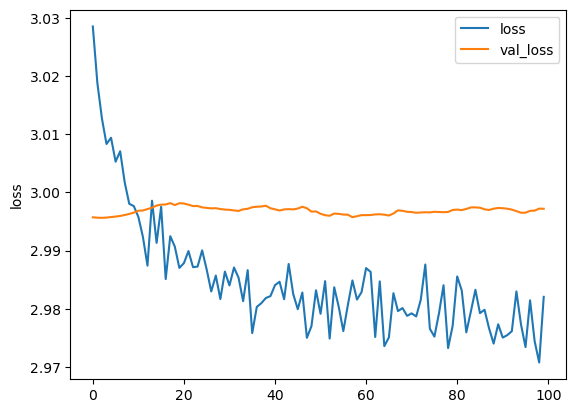

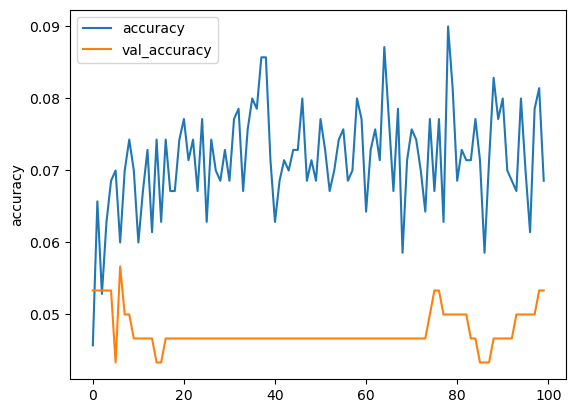

In [197]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()


In [198]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("Accuracy %s" % accuracy_score(y_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy 0.0


/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


# LSTM

In [201]:
from keras.layers import LSTM

In [202]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation="sigmoid"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )

    return model

In [207]:
es = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [es]

In [208]:
lstm = build_lstm(n_timesteps, n_outputs)
lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,940 (1.08 MB)

 Trainable params: 281,940 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
lstm.fit(
    X_train_cnn,
    y_train,
    epochs=20,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.0429 - loss: 2.9971 - val_accuracy: 0.0367 - val_loss: 2.9963
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.0558 - loss: 2.9918 - val_accuracy: 0.0800 - val_loss: 2.9980
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.0619 - loss: 2.9881 - val_accuracy: 0.0500 - val_loss: 3.0043
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.0475 - loss: 2.9920 - val_accuracy: 0.0267 - val_loss: 3.0038
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.0492 - loss: 2.9916 - val_accuracy: 0.0367 - val_loss: 3.0043
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.0642 - loss: 2.9873 - val_accuracy: 0.0367 - val_loss: 3.0093
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.0706 - loss: 2.9908 - val_accuracy: 0.0367 - val_loss: 3.0042
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.0692 - loss: 2.9899 - val_accuracy: 0.0367 

In [210]:
summary = pd.DataFrame(lstm.history.history)
summary

,accuracy,loss,val_accuracy,val_loss
0,0.038571,2.997292,0.036667,2.996339
1,0.055714,2.992734,0.080000,2.998041
2,0.058571,2.987294,0.050000,3.004256
3,0.050000,2.989107,0.026667,3.003756
4,0.051429,2.989251,0.036667,3.004341
5,0.064286,2.985206,0.036667,3.009336
6,0.057143,2.988880,0.036667,3.004222
7,0.068571,2.987026,0.036667,3.005099
8,0.054286,2.985550,0.036667,3.006829
9,0.065714,2.985812,0.036667,3.005931


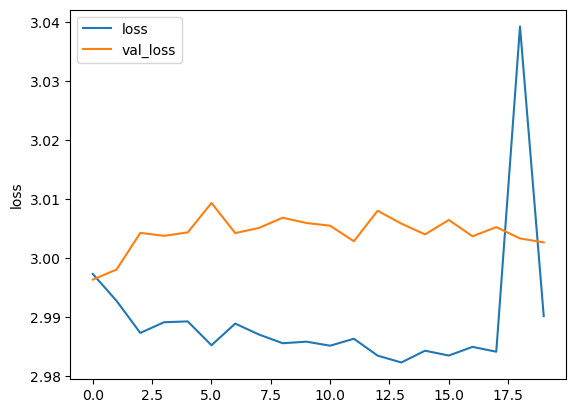

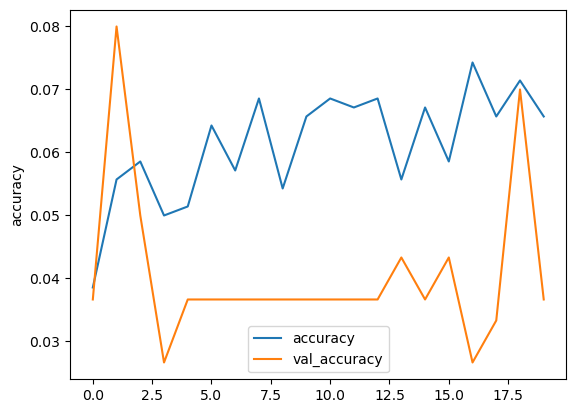

In [211]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [212]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print("Accuracy %s" % accuracy_score(y_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Accuracy 0.0


/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


# Rocket

In [213]:
from sktime.classification.kernel_based import RocketClassifier

In [214]:
rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1)

In [ ]:
%%time
rocket.fit(X_train_scaled, y_train)
rocket.score(X_test_scaled, y_test)

In [215]:
%%time
rocket.fit(X_train_scaled, y_train)
rocket.score(X_test_scaled, y_test)

CPU times: user 20.5 s, sys: 1.17 s, total: 21.7 s
Wall time: 16.4 s


/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

### Muse

In [216]:
from sktime.classification.dictionary_based import MUSE

In [217]:
muse = MUSE()

In [218]:
%%time
muse.fit(X_train_scaled, y_train)
muse.score(X_test_scaled, y_test)

/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sktime/transformations/panel/dictionary_based/_sfa_fast_numba.py:54: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  return_val = _fast_fourier_transform(


CPU times: user 1min 19s, sys: 7.06 s, total: 1min 26s
Wall time: 26.8 s


/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

#Cif

In [219]:
from sktime.classification.interval_based import CanonicalIntervalForest

In [220]:
cif = CanonicalIntervalForest(n_estimators=10)

In [221]:
%%time
cif.fit(X_train_scaled, y_train)
cif.score(X_test_scaled, y_test)

CPU times: user 57.6 s, sys: 1.47 s, total: 59.1 s
Wall time: 59.1 s


/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

# baseline

In [226]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_test)

dummy_clf.score(X_test, y_test)


/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0